# QCoDeS Example with Keysight 344xxA

`344xxA` models of Keysight digital multimeters have similar QCoDeS drivers. In this tutorial, `Keysight_34465A` is chosen for showcasing the usage of the instrument.

Note however that not every feature/parameter is available on all `344xxA` models. This, when possible, is reflected in the instantiated driver object. Also note that models like `34465A` have options (like `DIG` and `MEM`) that can either be enabled or disabled on a particular instrument; this also has impact on availability of some features/parameters and/or their settings. In general, refer to the instrument's manual for detailed information.

__NOTE__: Beginning with firmware revision 3.0, the digitizing and advanced triggering option, referred to as "DIG", for models 34465A-DIG/34470A-DIG, is now standard.

The driver does not cover all the features of the instrument. __At present, the driver only supports being used to measure DC Voltage__

__NOTE__: use drivers for these models which originate from `*_submodules` python modules, from example:
```python
from qcodes.instrument_drivers.Keysight.Keysight_34465A_submodules import Keysight_34465A
```
instead of
```python
from qcodes.instrument_drivers.Keysight.Keysight_34465A import Keysight_34465A
```
The latter ones are deprecated due to their deficiencies.

In [1]:
import time

import numpy

import qcodes
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_dataset
from qcodes.instrument_drivers.Keysight.Keysight_34465A_submodules import Keysight_34465A

In [2]:
dmm = Keysight_34465A('dmm', 'TCPIP0::172.20.2.182::inst0::INSTR')

Connected to: Keysight Technologies 34465A (serial:MY54505281, firmware:A.03.00-02.40-03.00-00.52-02-01) in 0.81s


In [3]:
dmm.reset()

## Parameters and methods overview

Here is an overview (not exhaustive) of the parameters and methods that are available in the driver.

The driver is not only comprised of root-level parameters and methods but also contains submodules which logically group some functionality.

* Measurements
  * `dmm.init_measurement()`
  * `dmm.fetch()`
  * `dmm.read()`
  * `dmm.volt` - immediately measure one (the present) voltage value
* Time trace measurements
  * `dmm.timetrace` - covered in more detail below
  * `dmm.time_axis`
  * `dmm.timetrace_dt`
  * `dmm.timetrace_npts`
* Range settings
  * `dmm.range`
  * `dmm.autorange`
  * `dmm.autorange_once()`
* Triggering
  * `dmm.trigger.source`
  * `dmm.trigger.delay`
  * `dmm.trigger.auto_delay_enabled`
  * `dmm.trigger.count`
  * `dmm.trigger.slope`
  * `dmm.trigger.level`
  * `dmm.trigger.force()`
* Sample settings
  * `dmm.sample.count`
  * `dmm.sample.source`
  * `dmm.sample.timer`
  * `dmm.sample.pretrigger_count`
* Display control
  * `dmm.display.text`
  * `dmm.display.clear()`
  * `dmm.display.enabled`
* Measurement type
  * `dmm.sense_function`
* Measurement accuracy (NB: DC Voltage mode only)
  * `dmm.NPLC`
  * `dmm.resolution`
  * `dmm.line_frequency`
  * `dmm.aperture_mode`
  * `dmm.aperture_time`
  * `dmm.autozero`

As an extra, let's print the readable snapshot of the instrument.

In [4]:
dmm.print_readable_snapshot(update=True)

dmm:
	parameter     value
--------------------------------------------------------------------------------
IDN            :	{'vendor': 'Keysight Technologies', 'model': '34465A', 'seri...
NPLC           :	10 (NPLC)
aperture_mode  :	OFF 
aperture_time  :	0.1 
autorange      :	ON 
autozero       :	ON 
line_frequency :	50 (Hz)
range          :	0.1 
resolution     :	1e-08 (V)
sense_function :	DC Voltage 
time_axis      :	Not available (s)
timeout        :	5 (s)
timetrace      :	Not available 
timetrace_dt   :	0.1 (s)
timetrace_npts :	500 
volt           :	-6.8847e-05 (V)
dmm_display:
	parameter value
--------------------------------------------------------------------------------
enabled :	True 
text    :	 
dmm_trigger:
	parameter         value
--------------------------------------------------------------------------------
auto_delay_enabled :	True 
count              :	1 
delay              :	0.00016 (s)
level              :	0 (V)
slope              :	NEG 
source             :	IMM 
dmm_s

## Single value reading

If one simpy wants to measure a single voltage value right now, the convenient `volt` parameter can be used.

This is a convenience parameter that does not utilize the full power of the instrument. In the next two sections, we will present more prowerful and robust ways of performing measurements.

In [5]:
dmm.volt()

-2.37353173e-05

## Time trace type measurements

For the commonly occuring case were one would like to measure N voltage points equidistantly spaced in time, the Keysight DMM driver offers the convenient `timetrace` parameter. It comes with three associated (helper) parameters:

 - `timetrace_dt` - the time spacing between the acquired points
 - `timetrace_npts` - the number of points
 - `time_axis` - the corresponding time axis (np.array, starts at 0)
 - `timetrace` - the array of voltage values
 
Note that changing `timetrace_dt` and `timetrace_npts` does not change any corresponding setting on the instrument before `timetrace.get` is called. Once that happens, the state of the instrument is __temporarily__ switched into one compatible with performing a time trace measurement. This specifically means that we set
 
 - `trigger.count` to 1
 - `trigger.source` to "BUS" (internal trigger)
 - `sample.timer` to `timetrace_dt`
 - `sample.count` to `timetrace_npts`
 
After the acquisition has completed, the previous instrument settings are restored. This behaviour guarantees that calling `timetrace.get` always works, irrespective of instrument state. The only exception is if the specified `timetrace_dt` can not be realized with the present `dmm.NPLC` and/or `dmm.aperture_time` settings. If that is the case, the `timetrace.get` method will raise a `RuntimeError` with an instructive error message. The user may manually compare the value of `sample.timer_minimum` to the value of `timetrace_dt`.

The usage is straightforward.

In [6]:
meas = Measurement()
meas.register_parameter(dmm.timetrace)

dmm.NPLC(0.006)
dmm.timetrace_dt(0.02)
dmm.timetrace_npts(500)

print(f'Minimal allowable dt: {dmm.sample.timer_minimum()} s')

with meas.run() as datasaver:
    datasaver.add_result((dmm.timetrace, dmm.timetrace()),
                          (dmm.time_axis, dmm.time_axis()))
    
time_trace_ds = datasaver.dataset

Minimal allowable dt: 0.015525 s
Starting experimental run with id: 380


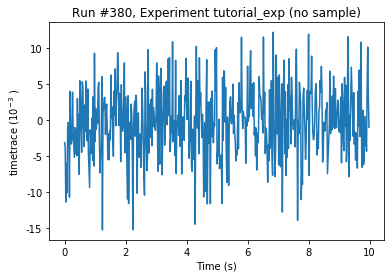

In [7]:
axs, cbs = plot_dataset(time_trace_ds)

## General guide: Multivalue triggered measurements

__NOTE__: Refer to the instrument manual for more information on how to perform measurements with the instrument; here, only the most basic and frequently used ones are demonstated.

Measurements with the instrument are performed in the following way: the instrument's settings are set for a particular kind of measurement, then the measurement is started/initialized, then after all the data has been acquired, it is retrieved from the instrument. Below is an example of such a measurement.

Use `range`, `autorange` parameters or `autorange_once` method to set the measurement range. Disabling autorange is recommended by the instrument's manual for speeding up the measurement.

In [8]:
dmm.autorange_once()

In order to set up the accuracy of the measurements and related settings, set up `NPLC` or `aperture_*` parameters (if available).

In [9]:
dmm.aperture_mode('ON')
dmm.aperture_time(2e-5)

Set up triggering mechanism. Note that trigger settings and methods are inside `trigger` submodule of the instrument driver. Here, we will use immediate triggering (the measurement is triggered uppon measurement initialization, that is when `init_measurement` is called) with 1 trigger without any delays. Consulm the instrument's manual for more information on various triggering options.

In [10]:
dmm.trigger.source('IMM')
dmm.trigger.count(1)
dmm.trigger.delay(0.0)

Set up sampling settings. Note that sampling parameters and method are inside `sample` submodule of the instrument driver. Here, we set to measure 15 samples.

In [11]:
dmm.sample.count(15)
dmm.sample.pretrigger_count(0)

We are also going to set the sample source to timer (not avaliable in all models) so that the instrument ensures that the samples are taken with fixed periods between them. The `timer` parameter allows to set the value of that fixed period. For simplicity, we are going to let the instrument deduce the minimum value of it according to the current instrument configuration (!) and set it.

In [12]:
dmm.sample.source('TIM')
dmm.sample.timer('MIN')

It turns out that commands are executed faster when the display of the instrument is disabled or is displaying text. One of the further section expands on it. Here, we will just set the display to some text.

In [13]:
dmm.display.text('Example with 15 samples')

In order to initiate the measurement, call `init_measurement` method of the driver. In the case of this example, the instrument will get into "wait-for-trigger" mode but because the trigger source is "immediate", the instrument will immediately start measuring the 15 samples.

In [14]:
dmm.init_measurement()

The instrument is going to measure 15 samples and save them to its memory. Once the measurement is completed, we can call `fetch` method of the driver to retreive the acquired data.

While the measurement is going, there are two things we can do. One is to `sleep` until the end of the measurement, and then call `fetch`. The other one is to call `fetch` immediately after the measurement has been initiated - this way the instrument will return the acquired data right when the measurement is finished. This sounds pretty useful, however there are two considerations to keep in mind: the instrument manual hints that calling fetching immediately after initiation may be slower than waiting for the measurement to complete; if the measurement takes longer than the VISA command timeout, the code may raise a VISA timeout exception while the measurement is properly running (e.g. waiting for a trigger). To overcome the latter consideration, one could in principle wrap `fetch` call into the following `try-finally` block that takes care of the VISA timeout value:
```python
old_timeout = dmm.visa_handle.timeout  # it is in milliseconds
new_timeout = old_timeout + n_samples * time_per_sample * 1000
# where, n_samples == dmm.sample.count(),
# and time_per_sample == dmm.sample.timer()
dmm.visa_handle.timeout = new_timeout
try:
    data = dmm.fetch()
finally:
    dmm.visa_handle.timeout = old_timeout
```

Assuming that we've just slept or waited enough for the measurement to complete, let's `fetch` the data from the instrument. Note that due to the nature of the `fetch` command of the instrument, one can fetch the same measured data more than once (until, for example, a new measurement has been initiated; refer to the instrument's manual for more information on this).

In [15]:
data = dmm.fetch()
data

array([ 0.00452534, -0.00368476, -0.01609807, -0.00400131, -0.00190267,
       -0.01231585, -0.00865626, -0.01178558, -0.00752636, -0.00628453,
        0.01104921, -0.00524739, -0.00187528, -0.03273147, -0.00153081])

Note that there is also a `read` method. It's difference from `fetch` is that it also initiates the new measurement. Using `read` might be convenient for some cases while `init_measurement` + `fetch` definitely allow for more control.

Since the measurement is finished, let's bring back the display to life.

In [16]:
dmm.display.clear()

If needed, it is straightforward to calculate a vector of times when the acquired data points were measured; for example, like this:

In [17]:
n = dmm.sample.count()
t = dmm.sample.timer()
setpoints = numpy.linspace(0, n*t, n)
setpoints  # in seconds

array([0.     , 0.00063, 0.00126, 0.00189, 0.00252, 0.00315, 0.00378,
       0.00441, 0.00504, 0.00567, 0.0063 , 0.00693, 0.00756, 0.00819,
       0.00882])

Note that for this simple type of measurement with measurement times being equidistantly spaced, the `timetrace` parameter is preferred.

## Special values of some parameters

Some parameters can be set to special values like `MIN`/`MAX`/`DEF` which usually mean minimum/maximum/default, respectively. 

In order to obtain the actual value of the parameter that gets set when setting it to one of these special values, just call the get method of the parameter.

In [18]:
# Find out what the maximum value of `sample_timer` can be
dmm.sample.timer('MAX')
dmm.sample.timer()

3600.0

In [19]:
# Find out what the default value of `sample_timer` is
dmm.sample.timer('DEF')
dmm.sample.timer()

1.0

In [20]:
# Find out what the recommended minumum value of `sample_timer` is
dmm.sample.timer('MIN')
dmm.sample.timer()

0.000588

In [21]:
# Alternatively, if available, use a conveniently implemented
# get-only parameter to find out the actual value,
# for example, for MIN value of `sample_timer` there is such
# a convenient get-only parameter:
dmm.sample.timer_minimum()

0.000588

## Display state impacts command execution speed

To improve the execution speed of commands on the instrument, the user may disable the display's updates. When the display is not updating, it may show a static message of up to 40 characters. The `timetrace` parameter (see above) makes use of this functionality to execute faster and at the same time display a message that a measurement is in progress.

The driver provides `display` submodule with `text` parameter that displays a given text on the insrturment, and a `clear` method that clears the text from display.

The driver's `display` submodule also provides `enabled` parameter. When it is set to `False`, the state of the display is such that it does not show anything. Note, however, that displaying text is still possible when the `display.enabled` is `False` (when `display.enabled` is `False`, `display.clear` clears the text from the screen but does not enable it).

In [22]:
# Displays the text
dmm.display.text('Hello, World!')

In [23]:
# Returns display to its normal state
dmm.display.clear()

In [24]:
# Note that a call to `display_clear` also updates 
# the value of the `display_text` parameter:
assert dmm.display.text() == ''

In [25]:
# Display can also be cleared by setting 
# `display_text` to an empty string
dmm.display.text('some text')  # Displays some text
time.sleep(0.5)
dmm.display.text('')  # Returns display to its normal state

In [26]:
# Disables the display, which makes it turn black
dmm.display.enabled(False)

In [27]:
# Shows some text on a disabled display
dmm.display.text("I'm disabled but still showing text")

In [28]:
# Enabling display in this state 
# won't change what's being displayed
dmm.display.enabled(True)

In [29]:
# ... but since the display is now enabled,
# clearing the display will not only remove the text
# but also show all the normal display indicators.
dmm.display.clear()

## Error handling

Use the following methods to read the error queue of the instrument. The instrument has an error queue of length up to 20 messages. The queue message retrieval is first-in-first-out.

In [30]:
# Retrieve the first (i.e. oldest) error message 
# in the queue (and thereby remove from the queue)
dmm.error()

(0, 'No error')

In [31]:
# The entire queue can be flushed out
# using `flush_error_queue` method.
# Printing the messages in enabled by default
# and can be disables with the `verbose` kwarg.

# generate a few errors
for _ in range(3):
    dmm.write('produce an error!')

In [32]:
dmm.flush_error_queue(verbose=True)

-113 Undefined header
-113 Undefined header
-113 Undefined header
0 No error
